In [36]:
from keras.layers import *
from keras.losses import mse
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Setup Google CoLab Environment

In [9]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/2.\ Autoencoder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/2. Autoencoder


# Importing relevant functions and libraries

In [0]:
%run "Reusable_Functions.ipynb"

# Import Data

In [12]:
# Import data offline
cplr, mech = import_DB()
print(cplr.shape)
print(mech.shape)

(1902, 100, 3)
(1902, 11, 3)


In [0]:
# Renormalize DB from range [-1,1] to range [0,1] 
n_cplr=cplr/2+.5
n_mech=mech/2+.5

# Splitting the database in Train/Test dataset

In [14]:
x= n_cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=1)

print(x_train.shape)
print(x_test.shape)

(1521, 100, 3)
(381, 100, 3)


# Variational Autoencoder (VAE)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_281 (InputLayer)          (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_115 (Flatten)           (None, 300)          0           input_281[0][0]                  
__________________________________________________________________________________________________
dense_529 (Dense)               (None, 150)          45150       flatten_115[0][0]                
__________________________________________________________________________________________________
dense_530 (Dense)               (None, 150)          22650       dense_529[0][0]                  
__________________________________________________________________________________________________
dense_531 

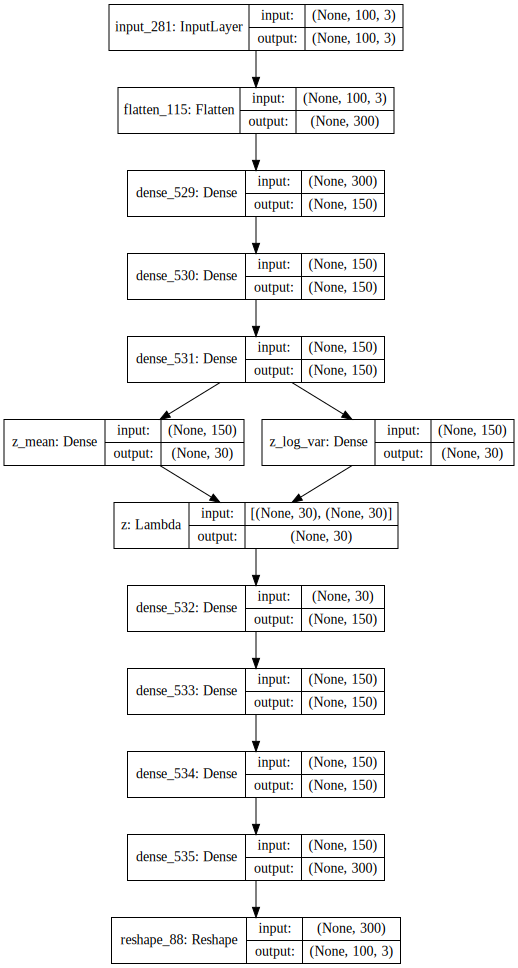

In [87]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    z_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.) * eps

def VAE_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(150, activation='relu')(z)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    # loss
    reconstruction_loss = mse(inp, y)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae,_=VAE_Z30()
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true').create(prog='dot', format='svg'))

In [88]:
#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')

train_data=vae.fit(x_train, x_train, shuffle=True, epochs=500, batch_size=128, validation_data=(x_test, x_test), verbose=0)
visualize_AE(vae, train_data, x_test)

NameError: name 'x_train' is not defined

# Conditional Variational Autoencoder (CVAE)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_300 (InputLayer)          (None, 100, 3)       0                                            
__________________________________________________________________________________________________
input_301 (InputLayer)          (None, 100, 1)       0                                            
__________________________________________________________________________________________________
concatenate_115 (Concatenate)   (None, 100, 4)       0           input_300[0][0]                  
                                                                 input_301[0][0]                  
__________________________________________________________________________________________________
flatten_124 (Flatten)           (None, 400)          0           concatenate_115[0][0]            
__________

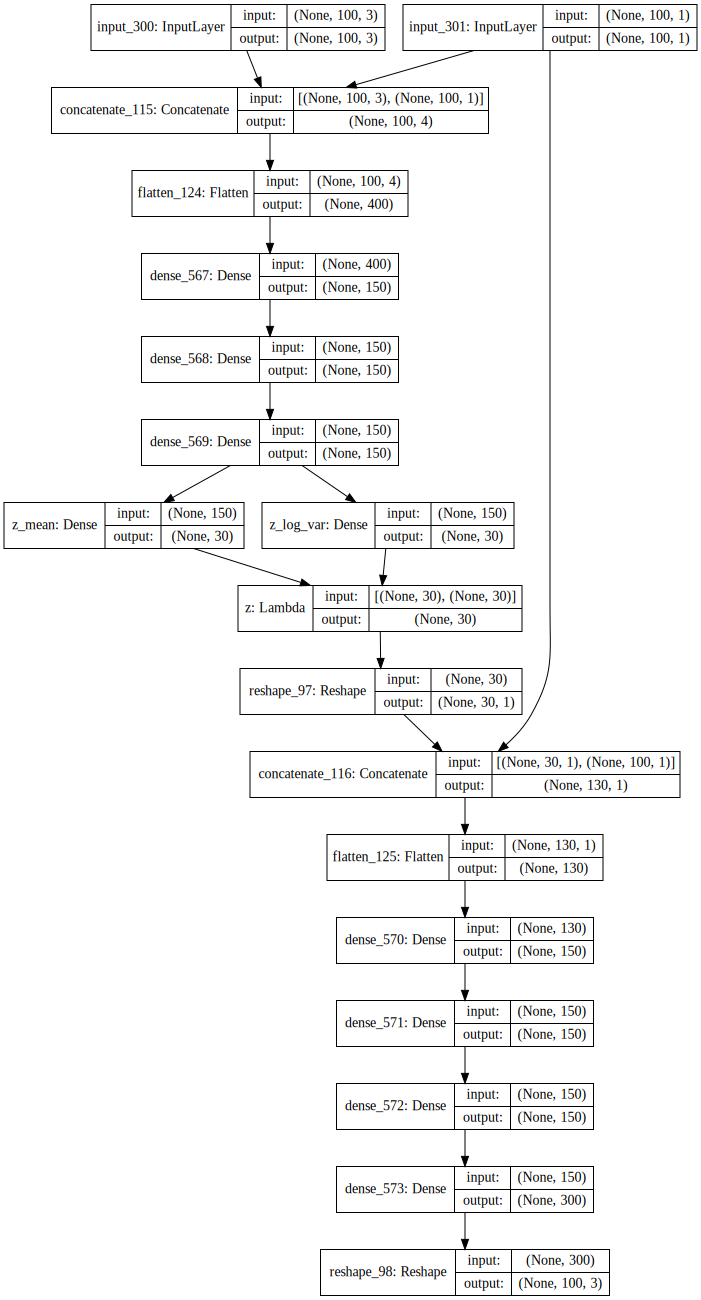

In [95]:
# Conditional VAE
# for path completion
# Train using mask and respective incomplete paths as input and full path as output.
def CVAE_Z30():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))

    # Encoding
    inp_cond= Concatenate()([inp, condition])
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    z = Reshape((z_dim, 1))(z)
    z_cond = Concatenate(axis=-2)([z, condition])
    x=Flatten()(z_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    # loss
    reconstruction_loss = mse(inp, y)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss

    # build model
    cvae = Model(inputs=[inp,condition], outputs=[y])
    cvae.add_loss(vae_loss)
    cvae.compile(optimizer='adam')
    cvae.summary()
    
    encoder = Model(inputs=[inp,condition], outputs=[z_mean])
    return cvae, encoder

cvae,_=CVAE_Z30()
SVG(model_to_dot(cvae, show_shapes='true', show_layer_names='true').create(prog='dot', format='svg'))

# Shared-encoder CVAE

In [90]:
# Shared Encoder CVAE
# Has single encoder and multiple decoders
# Used to generate DeepFake/FaceSwap

def SE_CVAE_encoder():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))

    # Encoding
    inp_cond= Concatenate()([inp, condition])
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])
    z = Reshape((z_dim, 1))(z)
    
    return Model(inputs=[inp,condition], outputs=[z,z_mean,z_log_var])
    
def SE_CVAE_decoder():
    z_dim=30
    z=Input(shape=(z_dim,1))
    condition=Input(shape=(100,1))

    # Encoding
    z_cond = Concatenate(axis=-2)([z, condition])
    x=Flatten()(z_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    return Model(inputs=[z,condition], outputs=[y])

def SE_CVAE():
    encoder = SE_CVAE_encoder()
    decoder_A = SE_CVAE_decoder()
    decoder_B = SE_CVAE_decoder()
    
    x = Input(shape=(100,3))
    m = Input(shape=(100,1))
    y1= decoder_A([encoder([x,m])[0],m])
    y2= decoder_B([encoder([x,m])[0],m])
    z_mean= encoder([x,m])[1]
    z_log_var= encoder([x,m])[2]
    print(z_mean)
    
    # loss
    reconstruction_loss1 = mse(x, y1)
    reconstruction_loss2 = mse(x, y2)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss1 = reconstruction_loss1 + kl_loss
    vae_loss2 = reconstruction_loss2 + kl_loss    

    # build model
    SE_CVAE_1 = Model(inputs=[x,m], outputs=[y1])
    SE_CVAE_2 = Model(inputs=[x,m], outputs=[y2])
    SE_CVAE_1.add_loss(vae_loss1)
    SE_CVAE_2.add_loss(vae_loss2)
    
    SE_CVAE_1.compile(optimizer='adam')
    SE_CVAE_2.compile(optimizer='adam')
    SE_CVAE_1.summary()
    SE_CVAE_2.summary()
    
    return SE_CVAE_1, SE_CVAE_2, encoder

SE_CVAE_1,SE_CVAE_2,_=SE_CVAE()

Tensor("model_125/z_mean/BiasAdd:0", shape=(?, 30), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_290 (InputLayer)          (None, 100, 3)       0                                            
__________________________________________________________________________________________________
input_291 (InputLayer)          (None, 100, 1)       0                                            
__________________________________________________________________________________________________
model_125 (Model)               [(None, 30, 1), (Non 114510      input_290[0][0]                  
                                                                 input_291[0][0]                  
__________________________________________________________________________________________________
model_126 (Model)               (None, 100

In [100]:
pbar = tqdm(range(100))
for epoch in pbar:
    autoencoder_A.fit(first_training, first_classes, batch_size=32, nb_epoch=1)
    autoencoder_B.fit(first_training, first_classes, batch_size=32, nb_epoch=1)
    #loss_A = autoencoder_A.train_on_batch([warped_A,mask_A], [target_A,mask_A])
    #loss_B = autoencoder_B.train_on_batch([warped_B,mask_B], [target_B,mask_B])
    #pbar.set_description("Loss A [{}] Loss B [{}]".format(loss_A,loss_B))
    #Track best model
    
    

NameError: name 'tqdm' is not defined

In [ ]:
# Disentangling VAE

In [1]:
# Deep feature consistent variational auto-encoder
# using 'feature perceptual loss' instead of 'reconstruction loss'
# needs a pre-trained 'perception model'

In [ ]:
# use domain knowledge and use multiple parallel input lambda layers for FDs, CAD, wavelets, etc